In [1]:
%load_ext nb_mypy
%nb_mypy Off

Version 1.0.5


In [2]:
from __future__ import annotations
import numpy as np
import random
import copy
import importlib

from typing import Tuple, List
from numpy import array, zeros

# from Big_Class import Big_Class  # already imported one NETfuncs is imported
from User_Variables import User_Variables  # already imported one NETfuncs is imported
from Network_Structure import Network_Structure  # already imported one NETfuncs is imported
from Big_Class import Big_Class
from Network_State import Network_State
from Networkx_Net import Networkx_Net
import matrix_functions, functions, statistics, plot_functions, solve, figure_plots

## Set up Network

In [3]:
## Parameters

## task type
# task_type='Iris_classification'
task_type='Regression'

## task matrix X
M_values: np.ndarray = array([0.15, 0.2, 0.25, 0.1, 0.02, 0.3, 0.35, 0.15, 0.03, 0.25, 0.1, 0.15, 0.02, 0.3, 0.35, 0.15, 0.03])
# M_values: np.ndarray = array([0.5, 0., 0., 0.1])

## specify # of nodes
Nin: int = 1
extraNin: int = 0
Ninter: int = 0
Nout: int = 2
extraNout: int = 0

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec: np.ndarray = np.array([0.2])  # for allostery, regression and general_reg
# alpha_vec = np.array([0.1])  # for general_reg_allRsChange
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])
alpha: float = 1.0  # for network combine attempt

# resistance-pressure proportionality factor
gamma: np.ndarray = np.array([1.0])

## method to update resistances - physical property of the system
R_update: str = 'R_propto_dp'
# R_update: str = 'deltaR_propto_dp'
# R_update: str = 'R_propto_Q'
# R_update: str = 'deltaR_propto_Q'
# R_update: str = 'deltaR_propto_Power'
# R_vec_i = array([1.9, 1., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 0.9, 3., 0.85, 1.05, 0.9, 1., 0.85, 1.05, 1., 2.95, 0.55])
# R_vec_i = array([3.74, 3.16, 1.38, -7.07, -3.01, 1.40, 1., 1., 1., 1., 1.])  # regression using 2in3out, M values [0.15, 0.2, 0.25, 0.1, 0.02, 0.3]
R_vec_i = np.ones(Nin*Nout + Nin + Nout)

# length of training dataset
iterations = 1600  # number of sampled of p

# measure accuracy every # steps
measure_accuracy_every = 15

supress_prints: bool = False  # whether to print information during training or not
bc_noise: float = 0.0  # noise to dual problem
# use_p_tag: bool = True  # use 1 or 2 sampled pressures at every time step
use_p_tag: bool = False
include_Power: bool = True
# include_Power: bool = False
lam = 0.018  # lambda parameter for penalty on Power dissipation
# lam = 5.0  # lambda parameter for penalty on Power dissipation

stay_sample: int = 2  # how many loop iterations to stay under the same sampled p
# stay_sample: int = 100

## Networkx sizes
scale: float = 50.0
squish: float = 0.01

In [4]:
## User Variables - Keep those since not in use Sep2024

access_interNodes: bool = False  # access and change pressure at interNodes (nodes between input and output) or not
noise_to_extra: bool = False  # add noise to extra outputs 

In [5]:
## Variables class - mostly user choices
Variabs = User_Variables(iterations,\
                         Nin, \
                         extraNin, \
                         Ninter, \
                         Nout, \
                         extraNout, \
                         gamma, \
                         R_update, \
                         use_p_tag, \
                         include_Power, lam, \
                         supress_prints, \
                         bc_noise, \
                         access_interNodes, \
                         task_type, \
                         M_values, \
                         measure_accuracy_every)
Variabs.assign_alpha_vec(alpha)
print('alpha_vec', Variabs.alpha_vec)
Variabs.create_dataset_and_targets(M_values)
Variabs.create_noise_for_extras()

alpha_vec [1. 1.]
input M mismatches output and input
no extra input nodes, no noise added
no inter nodes, no noise added
no extra output nodes, no noise added


In [6]:
## Assign input and output nodes a.f.o lattice size and row choice
inInterOutGround_tuple = matrix_functions.build_input_output_and_ground(Variabs.Nin, Variabs. extraNin, Variabs.Ninter, 
                                                                        Variabs.Nout, Variabs.extraNout)

In [7]:
print('input_nodes_arr ', inInterOutGround_tuple[0])
print('extraInput_nodes_arr ', inInterOutGround_tuple[1])
print('inter_nodes_arr ', inInterOutGround_tuple[2])
print('output_nodes_arr ', inInterOutGround_tuple[3])
print('extraOutput_nodes_arr ', inInterOutGround_tuple[4])
print('ground_nodes_arr ', inInterOutGround_tuple[5])

input_nodes_arr  [0]
extraInput_nodes_arr  []
inter_nodes_arr  []
output_nodes_arr  [1 2]
extraOutput_nodes_arr  []
ground_nodes_arr  [3]


In [8]:
## Big Class containing all classes in Network Simulation
BigClass = Big_Class(Variabs)

In [9]:
## Structure class - build incidence matrices and 1d arrays of edges

Strctr = Network_Structure(inInterOutGround_tuple)
if Ninter >= 1:
    Strctr.build_incidence('partialInter')
else:
    Strctr.build_incidence()
Strctr.build_edges()
BigClass.add_Strctr(Strctr)  # add to big class

In [10]:
## Initiate internal flow network state class

State = Network_State(Variabs)
if task_type == 'Iris_classification':
    State.initiate_resistances(BigClass, R_vec_i)
    State.initiate_accuracy_vec(BigClass, measure_accuracy_every)
else:
    State.initiate_resistances(BigClass, R_vec_i)
BigClass.add_State(State)  # add to big class

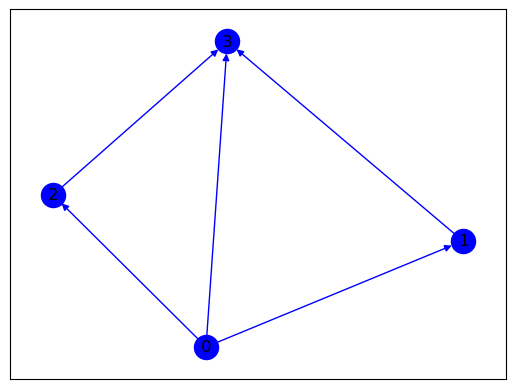

NET is ready


In [11]:
## build network graphics class and plot structure

NET = Networkx_Net(scale, squish)
NET.buildNetwork(BigClass)
NET.build_pos_lattice(BigClass, plot=True, node_labels=True)
BigClass.add_NET(NET)  # add to big class

In [12]:
Strctr.EIEJ_plots

[(0, 1), (0, 2), (0, 3), (1, 3), (2, 3)]

## Train

In [13]:
for i in range(Variabs.iterations):
    print('i', i)
    
    # if task is classification and iteration # is beginning of epoch
    # draw output of network as output of mean of Irises
    if i % iterations == 0 and task_type == 'Iris_classification':
        State.assign_targets_Iris(BigClass)

    # staying stay_sample iteration under same sample
    if use_p_tag and noise_to_extra:
        k = 2*(i//stay_sample) + 1
        if not(i%4):
            k-=1
    elif use_p_tag and not(noise_to_extra):
        k = (i//stay_sample)*2 + i%2
    elif not(use_p_tag) and noise_to_extra:
        k = (i//stay_sample)
    else:
        k = (i//stay_sample)
    print('k', k)
    
    # draw input and desired outputs from dataset
    if not((i+1) % 4):  # add noise only at i=3 etc.
        State.draw_p_in_and_desired(Variabs, k, noise_to_extra=noise_to_extra)  # add noise to extra nodes every 2nd iteration
        State.solve_flow_given_problem(BigClass, "measure", noise_to_extra=noise_to_extra)  # measure and don't change resistances
    else:  # dont add noise to extra nodes
        State.draw_p_in_and_desired(Variabs, k)
        State.solve_flow_given_problem(BigClass, "measure")
        
    if include_Power:
        State.calc_Power_norm(BigClass)
    
    if not i % 2 and use_p_tag:  # even iterations, take another sampled pressure and measure again
        pass
    else:  # odd iterations, go to dual problem and update resistances
        State.t += 1
        print('time=', State.t)
        State.calc_loss(BigClass)
        print('loss', State.loss)
        if not((i+1) % 4) and access_interNodes:
            print('updating inters')
            State.update_inter_dual(BigClass)
            print('solving dual problem')
            State.solve_flow_given_problem(BigClass, "dual", access_inters=True)  # measure and don't change resistances
        else:
            State.update_input_dual(BigClass)
            # State.update_extraInput_dual(BigClass)
            State.update_output_dual(BigClass)
            # State.update_extraOutput_dual(BigClass)
            print('solving dual problem')
            State.solve_flow_given_problem(BigClass, "dual", access_inters=False)  # measure and don't change resistances
        # print('p', State.p)
        # print('u', State.u)
        print('updating Rs')
        State.update_Rs(BigClass)
        # print('Rs', State.R_in_t[-1])
        
    # measure accuracy
    if i % measure_accuracy_every == 0 and task_type == 'Iris_classification' \
       and i//measure_accuracy_every<len(State.accuracy_in_t) and i>0:
        State.calculate_accuracy_fullDataset(BigClass)
        State.accuracy_in_t[i//measure_accuracy_every] = State.accuracy 
        State.t_for_accuracy[i//measure_accuracy_every] = State.t 

i 0
k 0
input_drawn [0.74908024]
desired output= [0.11236204 0.14981605]
output measured= [0.37454012 0.37454012]
Power dissipation normalized 2.0000000000000004
time= 1
using power
loss before power [[-0.26217808 -0.22472407]]
loss after power  [[-0.22617808 -0.18872407]]
loss [[-0.22617808 -0.18872407]]
input_dual_nxt= [1.310795]
output_dual_nxt [0.41528723 0.42931526]
solving dual problem
updating Rs
i 1
k 0
input_drawn [0.74908024]
desired output= [0.11236204 0.14981605]
output measured= [0.23732426 0.24534086]
Power dissipation normalized 2.2886873917497828
time= 2
using power
loss before power [[-0.12496223 -0.09552482]]
loss after power  [[-0.08376586 -0.05432844]]
loss [[-0.08376586 -0.05432844]]
input_dual_nxt= [1.41423872]
output_dual_nxt [0.39540756 0.41598628]
solving dual problem
updating Rs
i 2
k 1
input_drawn [1.90142861]
desired output= [0.28521429 0.38028572]
output measured= [0.53162118 0.55928904]
Power dissipation normalized 2.121282614903375
time= 3
using power
los

output measured= [0.1085008  0.13967523]
Power dissipation normalized 1.7608526408494896
time= 93
using power
loss before power [[-0.01498748 -0.0149908 ]]
loss after power  [[0.01670787 0.01670455]]
loss [[0.01670787 0.01670455]]
input_dual_nxt= [1.68289004]
output_dual_nxt [0.29832938 0.38404486]
solving dual problem
updating Rs
i 93
k 46
input_drawn [0.62342215]
desired output= [0.09351332 0.12468443]
output measured= [0.11051533 0.1422684 ]
Power dissipation normalized 1.7826476654711063
time= 94
using power
loss before power [[-0.01700201 -0.01758397]]
loss after power  [[0.01508565 0.01450369]]
loss [[0.01508565 0.01450369]]
input_dual_nxt= [1.66444339]
output_dual_nxt [0.29999658 0.38610828]
solving dual problem
updating Rs
i 94
k 47
input_drawn [1.04013604]
desired output= [0.15602041 0.20802721]
output measured= [0.18747243 0.24128495]
Power dissipation normalized 1.802404347651411
time= 95
using power
loss before power [[-0.03145203 -0.03325774]]
loss after power  [[ 0.000991

updating Rs
i 225
k 112
input_drawn [1.8593953]
desired output= [0.2789093  0.37187906]
output measured= [0.3046792  0.38719525]
Power dissipation normalized 1.7051641255669925
time= 226
using power
loss before power [[-0.02576991 -0.01531619]]
loss after power  [[0.00492305 0.01537677]]
loss [[0.00492305 0.01537677]]
input_dual_nxt= [1.72161606]
output_dual_nxt [0.28978767 0.37231829]
solving dual problem
updating Rs
i 226
k 113
input_drawn [1.61624076]
desired output= [0.24243611 0.32324815]
output measured= [0.27205058 0.34952973]
Power dissipation normalized 1.7425488026132496
time= 227
using power
loss before power [[-0.02961447 -0.02628158]]
loss after power  [[0.00175141 0.0050843 ]]
loss [[0.00175141 0.0050843 ]]
input_dual_nxt= [1.7105679]
output_dual_nxt [0.29026415 0.3740954 ]
solving dual problem
updating Rs
i 227
k 113
input_drawn [1.61624076]
desired output= [0.24243611 0.32324815]
output measured= [0.27425789 0.35346638]
Power dissipation normalized 1.7538035176682818
ti

updating Rs
i 310
k 155
input_drawn [0.48411054]
desired output= [0.07261658 0.09682211]
output measured= [0.08121762 0.10486691]
Power dissipation normalized 1.7613670069799683
time= 311
using power
loss before power [[-0.00860104 -0.0080448 ]]
loss after power  [[0.02310357 0.02365981]]
loss [[0.02310357 0.02365981]]
input_dual_nxt= [1.6805839]
output_dual_nxt [0.28762041 0.37142926]
solving dual problem
updating Rs
i 311
k 155
input_drawn [0.48411054]
desired output= [0.07261658 0.09682211]
output measured= [0.0828522  0.10699425]
Power dissipation normalized 1.7850938556795415
time= 312
using power
loss before power [[-0.01023562 -0.01017215]]
loss after power  [[0.02189607 0.02195954]]
loss [[0.02189607 0.02195954]]
input_dual_nxt= [1.65935294]
output_dual_nxt [0.28943455 0.37377881]
solving dual problem
updating Rs
i 312
k 156
input_drawn [1.34427109]
desired output= [0.20164066 0.26885422]
output measured= [0.23447603 0.30280481]
Power dissipation normalized 1.8079336417803074
t

output measured= [0.08418105 0.10795492]
Power dissipation normalized 1.8392543378406803
time= 432
using power
loss before power [[-0.01300632 -0.01305528]]
loss after power  [[0.02010026 0.02005129]]
loss [[0.02010026 0.02005129]]
input_dual_nxt= [1.61204395]
output_dual_nxt [0.29106588 0.37326156]
solving dual problem
updating Rs
i 432
k 216
input_drawn [0.6507994]
desired output= [0.09761991 0.13015988]
output measured= [0.11750641 0.15068969]
Power dissipation normalized 1.8609914475701597
time= 433
using power
loss before power [[-0.0198865  -0.02052981]]
loss after power  [[0.01361134 0.01296804]]
loss [[0.01361134 0.01296804]]
input_dual_nxt= [1.5947461]
output_dual_nxt [0.2926653  0.37521571]
solving dual problem
updating Rs
i 433
k 216
input_drawn [0.6507994]
desired output= [0.09761991 0.13015988]
output measured= [0.11943368 0.15312165]
Power dissipation normalized 1.8811771956287238
time= 434
using power
loss before power [[-0.02181378 -0.02296177]]
loss after power  [[0.01

output measured= [0.09792286 0.12536108]
Power dissipation normalized 1.8317150876370514
time= 473
using power
loss before power [[-0.01369115 -0.01305213]]
loss after power  [[0.01927972 0.01991874]]
loss [[0.01927972 0.01991874]]
input_dual_nxt= [1.61579761]
output_dual_nxt [0.28749112 0.36812693]
solving dual problem
updating Rs
i 473
k 236
input_drawn [0.56154472]
desired output= [0.08423171 0.11230894]
output measured= [0.09991296 0.12793665]
Power dissipation normalized 1.8566681758930612
time= 474
using power
loss before power [[-0.01568125 -0.01562771]]
loss after power  [[0.01773877 0.01779232]]
loss [[0.01773877 0.01779232]]
input_dual_nxt= [1.59584531]
output_dual_nxt [0.28926346 0.37040322]
solving dual problem
updating Rs
i 474
k 237
input_drawn [0.04863193]
desired output= [0.00729479 0.00972639]
output measured= [0.00881504 0.0112877 ]
Power dissipation normalized 1.879881452028596
time= 475
using power
loss before power [[-0.00152025 -0.00156131]]
loss after power  [[0.

updating Rs
i 563
k 281
input_drawn [0.67599031]
desired output= [0.10139855 0.13519806]
output measured= [0.11684735 0.15110776]
Power dissipation normalized 1.8407399303538021
time= 564
using power
loss before power [[-0.01544881 -0.0159097 ]]
loss after power  [[0.01768451 0.01722362]]
loss [[0.01768451 0.01722362]]
input_dual_nxt= [1.60618183]
output_dual_nxt [0.28377961 0.36691601]
solving dual problem
updating Rs
i 564
k 282
input_drawn [0.75116591]
desired output= [0.11267489 0.15023318]
output measured= [0.13271571 0.17159626]
Power dissipation normalized 1.8677835485184915
time= 565
using power
loss before power [[-0.02004083 -0.02136308]]
loss after power  [[0.01357928 0.01225703]]
loss [[0.01357928 0.01225703]]
input_dual_nxt= [1.58677448]
output_dual_nxt [0.28558179 0.36901927]
solving dual problem
updating Rs
i 565
k 282
input_drawn [0.75116591]
desired output= [0.11267489 0.15023318]
output measured= [0.13519206 0.17469067]
Power dissipation normalized 1.89062783390101
ti

updating Rs
i 603
k 301
input_drawn [1.06270926]
desired output= [0.15940639 0.21254185]
output measured= [0.19408675 0.24823833]
Power dissipation normalized 1.9053337809030726
time= 604
using power
loss before power [[-0.03468036 -0.03569648]]
loss after power  [[-0.00038435 -0.00140047]]
loss [[-0.00038435 -0.00140047]]
input_dual_nxt= [1.57642402]
output_dual_nxt [0.28748748 0.36744628]
solving dual problem
updating Rs
i 604
k 302
input_drawn [1.08127024]
desired output= [0.16219054 0.21625405]
output measured= [0.19718785 0.25203164]
Power dissipation normalized 1.903041292159375
time= 605
using power
loss before power [[-0.03499731 -0.03577759]]
loss after power  [[-0.00074257 -0.00152285]]
loss [[-0.00074257 -0.00152285]]
input_dual_nxt= [1.57887354]
output_dual_nxt [0.28734105 0.36706248]
solving dual problem
updating Rs
i 605
k 302
input_drawn [1.08127024]
desired output= [0.16219054 0.21625405]
output measured= [0.19678164 0.25137778]
Power dissipation normalized 1.9000888411

output measured= [0.05779784 0.07430114]
Power dissipation normalized 1.8882525529799445
time= 708
using power
loss before power [[-0.00891751 -0.00912737]]
loss after power  [[0.02507103 0.02486118]]
loss [[0.02507103 0.02486118]]
input_dual_nxt= [1.57249917]
output_dual_nxt [0.28324187 0.36410173]
solving dual problem
updating Rs
i 708
k 354
input_drawn [0.14113749]
desired output= [0.02117062 0.0282275 ]
output measured= [0.02542198 0.03267945]
Power dissipation normalized 1.9077911464893305
time= 709
using power
loss before power [[-0.00425136 -0.00445195]]
loss after power  [[0.03008888 0.02988829]]
loss [[0.03008888 0.02988829]]
input_dual_nxt= [1.56403415]
output_dual_nxt [0.28400679 0.36507846]
solving dual problem
updating Rs
i 709
k 354
input_drawn [0.14113749]
desired output= [0.02117062 0.0282275 ]
output measured= [0.0256286  0.03294446]
Power dissipation normalized 1.9181166916367003
time= 710
using power
loss before power [[-0.00445798 -0.00471696]]
loss after power  [[0

output measured= [0.0066091  0.00856213]
Power dissipation normalized 1.926863108630486
time= 743
using power
loss before power [[-0.00114255 -0.0012734 ]]
loss after power  [[0.03354099 0.03341014]]
loss [[0.03354099 0.03341014]]
input_dual_nxt= [1.55449474]
output_dual_nxt [0.28257352 0.36607465]
solving dual problem
updating Rs
i 743
k 371
input_drawn [0.03644365]
desired output= [0.00546655 0.00728873]
output measured= [0.00662467 0.00858227]
Power dissipation normalized 1.9298875235862678
time= 744
using power
loss before power [[-0.00115812 -0.00129354]]
loss after power  [[0.03357986 0.03344443]]
loss [[0.03357986 0.03344443]]
input_dual_nxt= [1.55205213]
output_dual_nxt [0.28279598 0.36636167]
solving dual problem
updating Rs
i 744
k 372
input_drawn [0.18888592]
desired output= [0.02833289 0.03777718]
output measured= [0.03441648 0.04458649]
Power dissipation normalized 1.932924768366137
time= 745
using power
loss before power [[-0.0060836  -0.00680931]]
loss after power  [[0.0

updating Rs
i 843
k 421
input_drawn [1.57923629]
desired output= [0.23688544 0.31584726]
output measured= [0.27102278 0.34900639]
Power dissipation normalized 1.8678342939583825
time= 844
using power
loss before power [[-0.03413734 -0.03315914]]
loss after power  [[-0.00051632  0.00046188]]
loss [[-0.00051632  0.00046188]]
input_dual_nxt= [1.60622416]
output_dual_nxt [0.27549965 0.35511283]
solving dual problem
updating Rs
i 844
k 422
input_drawn [0.18241221]
desired output= [0.02736183 0.03648244]
output measured= [0.03128735 0.04032869]
Power dissipation normalized 1.8677343236902155
time= 845
using power
loss before power [[-0.00392552 -0.00384625]]
loss after power  [[0.0296937  0.02977297]]
loss [[0.0296937  0.02977297]]
input_dual_nxt= [1.59537672]
output_dual_nxt [0.27642869 0.35631354]
solving dual problem
updating Rs
i 845
k 422
input_drawn [0.18241221]
desired output= [0.02736183 0.03648244]
output measured= [0.03160631 0.04074018]
Power dissipation normalized 1.8804336109553

updating Rs
i 880
k 440
input_drawn [0.16967543]
desired output= [0.02545131 0.03393509]
output measured= [0.03004298 0.03866289]
Power dissipation normalized 1.9116445632019203
time= 881
using power
loss before power [[-0.00459166 -0.0047278 ]]
loss after power  [[0.02981794 0.0296818 ]]
loss [[0.02981794 0.0296818 ]]
input_dual_nxt= [1.55923375]
output_dual_nxt [0.27876355 0.35874092]
solving dual problem
updating Rs
i 881
k 440
input_drawn [0.16967543]
desired output= [0.02545131 0.03393509]
output measured= [0.03033498 0.0390381 ]
Power dissipation normalized 1.924021978322623
time= 882
using power
loss before power [[-0.00488367 -0.00510301]]
loss after power  [[0.02974873 0.02952938]]
loss [[0.02974873 0.02952938]]
input_dual_nxt= [1.54917571]
output_dual_nxt [0.27966598 0.35989369]
solving dual problem
updating Rs
i 882
k 441
input_drawn [1.97327916]
desired output= [0.29599187 0.39465583]
output measured= [0.35622754 0.45841844]
Power dissipation normalized 1.9365137108336172
t

output measured= [0.22040944 0.28514543]
Power dissipation normalized 1.9405454136071594
time= 983
using power
loss before power [[-0.03436966 -0.03709239]]
loss after power  [[ 0.00056015 -0.00216257]]
loss [[ 0.00056015 -0.00216257]]
input_dual_nxt= [1.54794455]
output_dual_nxt [0.27485789 0.35480944]
solving dual problem
updating Rs
i 983
k 491
input_drawn [1.2402652]
desired output= [0.18603978 0.24805304]
output measured= [0.22022538 0.28428525]
Power dissipation normalized 1.9380539221871569
time= 984
using power
loss before power [[-0.0341856  -0.03623221]]
loss after power  [[ 0.00069937 -0.00134724]]
loss [[ 0.00069937 -0.00134724]]
input_dual_nxt= [1.54874808]
output_dual_nxt [0.27501191 0.35442644]
solving dual problem
updating Rs
i 984
k 492
input_drawn [0.55476237]
desired output= [0.08321435 0.11095247]
output measured= [0.09850941 0.12695574]
Power dissipation normalized 1.9370484109536954
time= 985
using power
loss before power [[-0.01529505 -0.01600326]]
loss after pow

updating Rs
i 1014
k 507
input_drawn [1.64507449]
desired output= [0.24676117 0.3290149 ]
output measured= [0.27884657 0.35946525]
Power dissipation normalized 1.886923482046285
time= 1015
using power
loss before power [[-0.03208539 -0.03045035]]
loss after power  [[0.00187923 0.00351427]]
loss [[0.00187923 0.00351427]]
input_dual_nxt= [1.58101688]
output_dual_nxt [0.27001653 0.34867005]
solving dual problem
updating Rs
i 1015
k 507
input_drawn [1.64507449]
desired output= [0.24676117 0.3290149 ]
output measured= [0.28095671 0.36279702]
Power dissipation normalized 1.8975129470107526
time= 1016
using power
loss before power [[-0.03419554 -0.03378212]]
loss after power  [[-4.03037992e-05  3.73112027e-04]]
loss [[-4.03037992e-05  3.73112027e-04]]
input_dual_nxt= [1.58046939]
output_dual_nxt [0.2700052  0.34880542]
solving dual problem
updating Rs
i 1016
k 508
input_drawn [1.89959983]
desired output= [0.28493997 0.37991997]
output measured= [0.32452501 0.41923666]
Power dissipation normal

updating Rs
i 1128
k 564
input_drawn [0.70117512]
desired output= [0.10517627 0.14023502]
output measured= [0.13238155 0.16982375]
Power dissipation normalized 2.0523694041860994
time= 1129
using power
loss before power [[-0.02720528 -0.02958873]]
loss after power  [[0.00973737 0.00735392]]
loss [[0.00973737 0.00735392]]
input_dual_nxt= [1.44974118]
output_dual_nxt [0.27726211 0.35527691]
solving dual problem
updating Rs
i 1129
k 564
input_drawn [0.70117512]
desired output= [0.10517627 0.14023502]
output measured= [0.13409931 0.17183159]
Power dissipation normalized 2.0693348902179634
time= 1130
using power
loss before power [[-0.02892304 -0.03159657]]
loss after power  [[0.00832499 0.00565146]]
loss [[0.00832499 0.00565146]]
input_dual_nxt= [1.43994124]
output_dual_nxt [0.27837848 0.35624801]
solving dual problem
updating Rs
i 1130
k 565
input_drawn [1.17983537]
desired output= [0.17697531 0.23596707]
output measured= [0.22809318 0.29189664]
Power dissipation normalized 2.083418349560

output measured= [0.32283083 0.41743261]
Power dissipation normalized 1.956977506231406
time= 1155
using power
loss before power [[-0.04485454 -0.04679756]]
loss after power  [[-0.00962895 -0.01157197]]
loss [[-0.00962895 -0.01157197]]
input_dual_nxt= [1.57226525]
output_dual_nxt [0.26394231 0.34047642]
solving dual problem
updating Rs
i 1155
k 577
input_drawn [1.85317525]
desired output= [0.27797629 0.37063505]
output measured= [0.31109977 0.40130791]
Power dissipation normalized 1.9080749948267217
time= 1156
using power
loss before power [[-0.03312348 -0.03067286]]
loss after power  [[0.00122187 0.00367249]]
loss [[0.00122187 0.00367249]]
input_dual_nxt= [1.56319514]
output_dual_nxt [0.26432243 0.34195022]
solving dual problem
updating Rs
i 1156
k 578
input_drawn [0.98423259]
desired output= [0.14763489 0.19684652]
output measured= [0.166425   0.21530169]
Power dissipation normalized 1.9191461880651728
time= 1157
using power
loss before power [[-0.01879011 -0.01845517]]
loss after po

updating Rs
i 1269
k 634
input_drawn [0.21434402]
desired output= [0.0321516 0.0428688]
output measured= [0.0395494  0.05077179]
Power dissipation normalized 2.057033720643349
time= 1270
using power
loss before power [[-0.0073978  -0.00790298]]
loss after power  [[0.02962881 0.02912363]]
loss [[0.02962881 0.02912363]]
input_dual_nxt= [1.44581747]
output_dual_nxt [0.27026853 0.3469332 ]
solving dual problem
updating Rs
i 1270
k 635
input_drawn [0.89482473]
desired output= [0.13422371 0.17896495]
output measured= [0.16727074 0.21471895]
Power dissipation normalized 2.074950715197822
time= 1271
using power
loss before power [[-0.03304703 -0.035754  ]]
loss after power  [[0.00430208 0.00159511]]
loss [[0.00430208 0.00159511]]
input_dual_nxt= [1.44054052]
output_dual_nxt [0.27098814 0.3472757 ]
solving dual problem
updating Rs
i 1271
k 635
input_drawn [0.89482473]
desired output= [0.13422371 0.17896495]
output measured= [0.16833049 0.21571826]
Power dissipation normalized 2.08255162015946
t

updating Rs
i 1297
k 648
input_drawn [1.57834248]
desired output= [0.23675137 0.3156685 ]
output measured= [0.27438034 0.35095021]
Power dissipation normalized 1.9996734318650278
time= 1298
using power
loss before power [[-0.03762897 -0.03528171]]
loss after power  [[-0.00163485  0.00071241]]
loss [[-0.00163485  0.00071241]]
input_dual_nxt= [1.5017009]
output_dual_nxt [0.26035524 0.33383496]
solving dual problem
updating Rs
i 1298
k 649
input_drawn [0.9968844]
desired output= [0.14953266 0.19937688]
output measured= [0.1728334  0.22161195]
Power dissipation normalized 1.997734707402288
time= 1299
using power
loss before power [[-0.02330074 -0.02223507]]
loss after power  [[0.01265848 0.01372415]]
loss [[0.01265848 0.01372415]]
input_dual_nxt= [1.47540046]
output_dual_nxt [0.26254305 0.3368764 ]
solving dual problem
updating Rs
i 1299
k 649
input_drawn [0.9968844]
desired output= [0.14953266 0.19937688]
output measured= [0.17739256 0.22761741]
Power dissipation normalized 2.033346257797

updating Rs
i 1407
k 703
input_drawn [0.26882935]
desired output= [0.0403244  0.05376587]
output measured= [0.05405133 0.06816801]
Power dissipation normalized 2.2758809002133384
time= 1408
using power
loss before power [[-0.01372693 -0.01440213]]
loss after power  [[0.02723892 0.02656372]]
loss [[0.02723892 0.02656372]]
input_dual_nxt= [1.30370718]
output_dual_nxt [0.26650622 0.33606403]
solving dual problem
updating Rs
i 1408
k 704
input_drawn [0.12674994]
desired output= [0.01901249 0.02534999]
output measured= [0.02591046 0.03267306]
Power dissipation normalized 2.3011302266140814
time= 1409
using power
loss before power [[-0.00689796 -0.00732307]]
loss after power  [[0.03452238 0.03409728]]
loss [[0.03452238 0.03409728]]
input_dual_nxt= [1.29500964]
output_dual_nxt [0.26740071 0.3371781 ]
solving dual problem
updating Rs
i 1409
k 704
input_drawn [0.12674994]
desired output= [0.01901249 0.02534999]
output measured= [0.02617202 0.03300153]
Power dissipation normalized 2.316585066144

output measured= [0.30345987 0.38983972]
Power dissipation normalized 2.276254476765072
time= 1539
using power
loss before power [[-0.05708268 -0.0613368 ]]
loss after power  [[-0.0161101  -0.02036422]]
loss [[-0.0161101  -0.02036422]]
input_dual_nxt= [1.37786418]
output_dual_nxt [0.23860759 0.30486881]
solving dual problem
updating Rs
i 1539
k 769
input_drawn [1.64251461]
desired output= [0.24637719 0.32850292]
output measured= [0.28443765 0.36342586]
Power dissipation normalized 2.1772828127924337
time= 1540
using power
loss before power [[-0.03806046 -0.03492294]]
loss after power  [[0.00113063 0.00426815]]
loss [[0.00113063 0.00426815]]
input_dual_nxt= [1.36899661]
output_dual_nxt [0.23892918 0.30641997]
solving dual problem
updating Rs
i 1540
k 770
input_drawn [0.22126347]
desired output= [0.03318952 0.04425269]
output measured= [0.03861682 0.04952499]
Power dissipation normalized 2.191385997316305
time= 1541
using power
loss before power [[-0.0054273 -0.0052723]]
loss after power

In [14]:
State.Power_norm
State.Power_norm_in_t[-2]

2.2799546032429006

## Is the network linear?

In [15]:
# # put pressure of 1 through 1st input
# State.input_drawn = np.array([1,0])

# # solve flow
# State.solve_flow_given_problem(BigClass, "measure")

# # measure power
# print('output 1', State.output)
# out1 = State.output

# # put pressure of 1 through 1st input
# State.input_drawn = np.array([0,1])

# # solve flow
# State.solve_flow_given_problem(BigClass, "measure")

# # measure power
# print('output 2', State.output)
# out2 = State.output

# print('superpose outputs', out1+out2)

# # put pressure of 1 through inputs
# State.input_drawn = np.ones(Nin)

# # solve flow
# State.solve_flow_given_problem(BigClass, "measure")

# # measure power
# print('output both', State.output)

## Plots

### importants + network

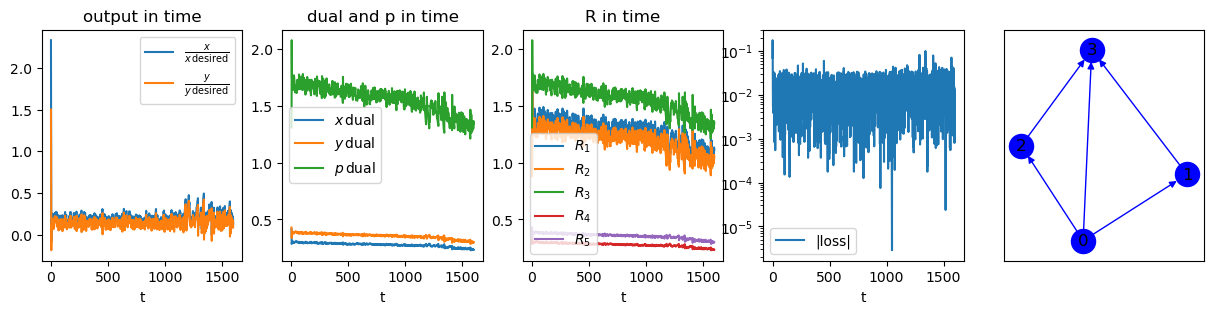

In [16]:
if hasattr(Variabs, 'M'):
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, Variabs.M, include_network=True, NET=NET)
else:
    plot_functions.plot_importants(State, Variabs, State.desired_in_t, include_network=True)

In [17]:
import importlib 
# Re-import the module import your_module 
importlib.reload(plot_functions)

<module 'plot_functions' from 'C:\\Users\\SMR_Admin\\OneDrive - huji.ac.il\\PhD\\Network Simulation repo\\Network combine\\Network_combine\\plot_functions.py'>

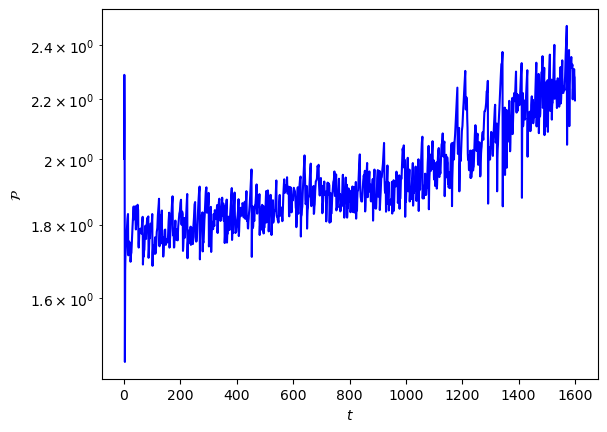

In [18]:
if np.size(State.Power_norm_in_t)>1:
    plot_functions.plot_Power(State)
else:
    pass

### accuracy

In [19]:
if task_type == 'Iris_classification':
    plot_functions.plot_accuracy(State.t, State.t_for_accuracy, State.accuracy_in_t, np.shape(Variabs.dataset)[0])
else:
    pass

In [20]:
# State.accuracy_in_t

In [21]:
State.output_in_t

[array([0.37454012, 0.37454012]),
 array([0.23732426, 0.24534086]),
 array([0.53162118, 0.55928904]),
 array([0.26052885, 0.30858401]),
 array([0.24286455, 0.29948908]),
 array([0.25037189, 0.31289559]),
 array([0.20663766, 0.26054397]),
 array([0.20925221, 0.2649221 ]),
 array([0.05489584, 0.06970332]),
 array([0.05561622, 0.07062821]),
 array([0.05632785, 0.07153965]),
 array([0.05704738, 0.0724587 ]),
 array([0.02150871, 0.02732023]),
 array([0.02163899, 0.02748571]),
 array([0.32465495, 0.41237355]),
 array([0.29361086, 0.37249249]),
 array([0.20355501, 0.26022427]),
 array([0.20730927, 0.26564792]),
 array([0.24672431, 0.3165441 ]),
 array([0.24523395, 0.31488948]),
 array([0.00711133, 0.00913989]),
 array([0.00712689, 0.00915988]),
 array([0.33654418, 0.43254621]),
 array([0.32128853, 0.41340775]),
 array([0.27741983, 0.35886729]),
 array([0.28028452, 0.36318787]),
 array([0.07159492, 0.09280161]),
 array([0.07281533, 0.09438414]),
 array([0.06337986, 0.08214702]),
 array([0.0643

## Power of trained network

put a pressure of 1 through all inputs and measure total power dissipation in a trained network that has the state State

In [22]:
# Reload the module to reflect any changes made
importlib.reload(statistics)

# put pressure of 1 through inputs
State.input_drawn = np.ones(Nin)

# solve flow
State.solve_flow_given_problem(BigClass, "measure")

# measure power
print('u', State.u)
print('Rs', State.R_in_t[-1])
print('Power dissipation', statistics.power_dissip(State.u, State.R_in_t[-1]))

output measured= [0.17304828 0.22284968]
u [0.74370703 0.74370703 0.74370703 0.74370703 0.74370703]
Rs [1.1119321  1.04496837 1.34461551 0.2326834  0.29964714]
Power dissipation 2.2311210779029995


## Save sizes to file

In [23]:
save_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/'
        
# np.save(save_folder_prelim + 't_2in1out.npy', State.t)
# np.save(save_folder_prelim + 'M_2in1out.npy', M_values)
# np.save(save_folder_prelim + 'output_2in1out_RproptoDeltap.npy', np.asarray(State.output_in_t)/np.asarray(State.desired_in_t)-1)
# np.save(save_folder_prelim + 'input_dual_2in1out_RproptoDeltap.npy', State.input_dual_in_t)
# np.save(save_folder_prelim + 'output_dual_2in1out_RproptoDeltap.npy', State.output_dual_in_t)
# np.save(save_folder_prelim + 'R_2in1out_RproptoDeltap.npy', State.R_in_t)
# np.save(save_folder_prelim + 'loss_2in1out_RproptoDeltap.npy', State.loss_in_t)

# import pickle
# # NET.NET networkx graph
# with open(save_folder_prelim + 'NETgraph_1in2out.pkl', 'wb') as f:
#     pickle.dump(NET.NET, f)
    
# # Save the dictionary to a file
# with open(save_folder_prelim + 'pos_lattice_1in2out.pkl', 'wb') as f:
#     pickle.dump(NET.pos_lattice, f)
      
# np.save(save_folder_prelim + 'output_2in1out.npy', np.asarray(State.output_in_t)/np.asarray(State.desired_in_t)-1)
# np.save(save_folder_prelim + 'input_dual_2in1out.npy', State.input_dual_in_t)
# np.save(save_folder_prelim + 'output_dual_2in1out.npy', State.output_dual_in_t)
# np.save(save_folder_prelim + 'R_2in1out.npy', State.R_in_t)
# np.save(save_folder_prelim + 'loss_2in1out.npy', State.loss_in_t)

# import pickle
# # NET.NET networkx graph
# with open(save_folder_prelim + 'NETgraph_2in1out.pkl', 'wb') as f:
#     pickle.dump(NET.NET, f)
    
# # Save the dictionary to a file
# with open(save_folder_prelim + 'pos_lattice_2in1out.pkl', 'wb') as f:
#     pickle.dump(NET.pos_lattice, f)

### R change scheme under 2 tasks

In [24]:
import pickle

load_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/importants_1in2out_n_2in1out/'

t = np.load(load_folder_prelim + 't_1in2out.npy')

loss_1in2out_R_propto_deltap = np.load(load_folder_prelim + 'loss_1in2out_RproptoDeltap.npy')
loss_1in2out_deltaR_propto_deltap = np.load(load_folder_prelim + 'loss_1in2out_deltaRproptoDeltap.npy')
loss_1in2out_propto_Q = np.load(load_folder_prelim + 'loss_1in2out_deltaRproptoQ.npy')
loss_1in2out_propto_Power = np.load(load_folder_prelim + 'loss_1in2out_deltaRproptoPower.npy')
loss_2in1out_R_propto_deltap = np.load(load_folder_prelim + 'loss_2in1out_RproptoDeltap.npy')
loss_2in1out_deltaR_propto_deltap = np.load(load_folder_prelim + 'loss_2in1out_deltaRproptoDeltap.npy')
loss_2in1out_propto_Q = np.load(load_folder_prelim + 'loss_2in1out_deltaRproptoQ.npy')
loss_2in1out_propto_Power = np.load(load_folder_prelim + 'loss_2in1out_deltaRproptoPower.npy')

with open(load_folder_prelim + 'NETgraph_1in2out.pkl', 'rb') as f:
    Network_1in2out = pickle.load(f)
    
with open(load_folder_prelim + 'NETgraph_2in1out.pkl', 'rb') as f:
    Network_2in1out = pickle.load(f)
    
with open(load_folder_prelim + 'pos_lattice_2in1out.pkl', 'rb') as f:
    pos_lattice = pickle.load(f) 

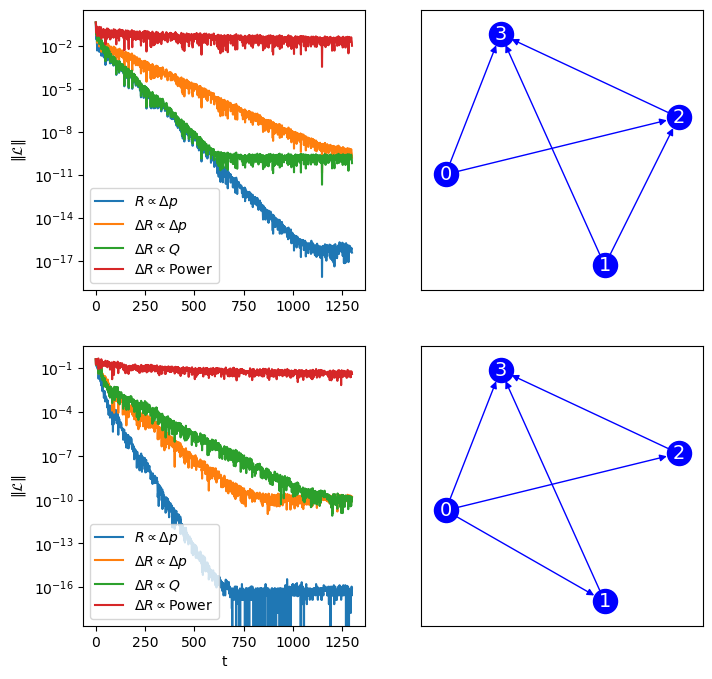

In [25]:
# Reload the module to reflect any changes made
importlib.reload(figure_plots)

figure_plots.plot_compare_R_type_loss(t, Network_1in2out, Network_2in1out, pos_lattice,
                         loss_1in2out_R_propto_deltap,
                         loss_1in2out_deltaR_propto_deltap,
                         loss_1in2out_propto_Q,
                         loss_1in2out_propto_Power,
                         loss_2in1out_R_propto_deltap,
                         loss_2in1out_deltaR_propto_deltap,
                         loss_2in1out_propto_Q,
                         loss_2in1out_propto_Power)

### 2 Network examples

In [26]:
import pickle

load_folder_prelim = 'C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/inner_variables_2examples/'

t = np.load(load_folder_prelim + 't.npy')
M = np.load(load_folder_prelim + 'M.npy')

output_1in2out = np.load(load_folder_prelim + 'output_1in2out.npy')
input_dual_1in2out = np.load(load_folder_prelim + 'input_dual_1in2out.npy')
output_dual_1in2out = np.load(load_folder_prelim + 'output_dual_1in2out.npy')
R_1in2out = np.load(load_folder_prelim + 'R_1in2out.npy')
loss_1in2out = np.load(load_folder_prelim + 'loss_1in2out.npy')

output_2in1out = np.load(load_folder_prelim + 'output_2in1out.npy')
input_dual_2in1out = np.load(load_folder_prelim + 'input_dual_2in1out.npy')
output_dual_2in1out = np.load(load_folder_prelim + 'output_dual_2in1out.npy')
R_2in1out = np.load(load_folder_prelim + 'R_2in1out.npy')
loss_2in1out = np.load(load_folder_prelim + 'loss_2in1out.npy')
with open(load_folder_prelim + 'NETgraph_1in2out.pkl', 'rb') as f:
    NET_1in2out = pickle.load(f)
    
with open(load_folder_prelim + 'pos_lattice_1in2out.pkl', 'rb') as f:
    pos_lattice_1in2out = pickle.load(f)
    
with open(load_folder_prelim + 'NETgraph_2in1out.pkl', 'rb') as f:
    NET_2in1out = pickle.load(f)
    
with open(load_folder_prelim + 'pos_lattice_2in1out.pkl', 'rb') as f:
    pos_lattice_2in1out = pickle.load(f)    

In [27]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

plot_functions.plot_performance_2(M, t, output_1in2out, output_2in1out, input_dual_1in2out, input_dual_2in1out, 
                                  output_dual_1in2out, output_dual_2in1out, R_1in2out, R_2in1out, loss_1in2out, loss_2in1out,
                                  NET_1in2out, NET_2in1out, pos_lattice_1in2out, pos_lattice_2in1out)

AttributeError: module 'plot_functions' has no attribute 'plot_performance_2'

### different R relations

In [ ]:
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_propto_deltap.npy', R_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_deltap.npy', deltaR_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_Q.npy', deltaR_propto_Q)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/deltaR_propto_Power.npy', deltaR_propto_Power)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_R_propto_deltap.npy', loss_R_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_deltaR_propto_deltap.npy', loss_deltaR_propto_deltap)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_propto_Q.npy', loss_propto_Q)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_propto_Power.npy', loss_propto_Power)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/t_final.npy', State.t)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/t_for_accuracy.npy', State.t_for_accuracy)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/accuracy.npy', State.accuracy_in_t)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/dataset_len.npy', np.shape(Variabs.dataset)[0])

In [ ]:
# Loading the array later
R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/R_propto_deltap.npy')
deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_deltap.npy')
deltaR_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_Q.npy')
deltaR_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/deltaR_propto_Power.npy')
loss_R_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_R_propto_deltap.npy')
loss_deltaR_propto_deltap = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_deltaR_propto_deltap.npy')
loss_propto_Q = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_propto_Q.npy')
loss_propto_Power = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/different physical dependence of resistance/loss_propto_Power.npy')

In [ ]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

In [ ]:
plot_functions.plot_comparison_R_type(R_propto_deltap, deltaR_propto_deltap, deltaR_propto_Q, deltaR_propto_Power,
                                      loss_R_propto_deltap, loss_deltaR_propto_deltap, loss_propto_Q, loss_propto_Power)

### pseudo vs. network comparison

In [ ]:
# R_in_t_network = State.R_in_t
# R_in_t_pseudo = State.R_in_t
# loss_network = State.loss_in_t
# loss_pseudo = State.loss_in_t

In [ ]:
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_in_t_network.npy', R_in_t_network)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/R_in_t_pseudo.npy', R_in_t_pseudo)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_in_t_network.npy', loss_network)
# np.save('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/Network combine/Network_combine/loss_in_t_pseudo.npy', loss_pseudo)

In [ ]:
# Loading the array later
R_in_t_network = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/R_in_t_network.npy')
R_in_t_pseudo = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/R_in_t_pseudo.npy')
loss_in_t_network = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/loss_in_t_network.npy')
loss_in_t_pseudo = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.8/30Aug_R_pseudo_vs_network/loss_in_t_pseudo.npy')

In [ ]:
# Reload the module to reflect any changes made
importlib.reload(plot_functions)

In [ ]:
plot_functions.plot_comparison_pseudo(R_in_t_pseudo, R_in_t_network, loss_in_t_pseudo, loss_in_t_network)

In [ ]:
t_final = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_pt8/t_final.npy')
t_for_accuracy = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_pt8/t_for_accuracy.npy')
accuracy_in_t = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_pt8/accuracy.npy')
dataset_len = np.load('C:/Users/SMR_Admin/OneDrive - huji.ac.il/PhD/Network Simulation repo/figs and data/2024.9/accuracy_pt8/dataset_len.npy')

In [ ]:
plot_functions.plot_accuracy(t_final, t_for_accuracy, accuracy_in_t, dataset_len)

## Statistics

### Error

In [ ]:
final_err = statistics.final_err(BigClass, 40)
print('final_err', final_err)

## Checks

In [ ]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import shuffle
from numpy.linalg import norm

In [ ]:
# Load the Iris dataset
iris = load_iris()
dataset, numerical_targets = shuffle(iris['data'], iris['target'], random_state=42)
# Min-Max Scale dataset to [0, 4]
min_max_scaler = MinMaxScaler(feature_range=(0, 4))
dataset = min_max_scaler.fit_transform(dataset)
# One-hot encode the label
encoder = OneHotEncoder(sparse_output=False, categories='auto')
targets_reshaped = numerical_targets.reshape(-1, 1)  # Reshape for the encoder
targets = encoder.fit_transform(targets_reshaped)